<a href="https://colab.research.google.com/github/mateuszkasprowicz/graph_representation_learning_workshops/blob/master/01_graph_feature_extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Graph feature extraction

## Setup

Install libraries:
- standard data science stack (Numpy, Pandas, Scikit-learn, tqdm)
- graph libraries (NetworkX, NetworKit)
- deep learning on graphs (PyTorch, PyTorch Scatter, PyTorch Geometric)

For PyTorch Scatter, we use a small workaround for Google Colab - change PyTorch or Python version if necessary.

In [ ]:
!pip install numpy pandas scikit-learn tqdm networkx networkit torch torch_geometric --extra-index-url https://download.pytorch.org/whl/cpu

In [ ]:

!pip install torch_scatter -f https://data.pyg.org/whl/torch-2.1.0%2Bcpu/torch_scatter-2.1.2%2Bpt21cpu-cp310-cp310-linux_x86_64.whl

## Data loading

We will use **IMDB-BINARY** dataset:
- a movie collaboration dataset
- each graph represents a set of actors playing in movies from genre: Action or Romance
- graphs are **ego-networks** (who-knows-whom), nodes are actors, edges mean that actors appear in the same movie
- statistics:
  - 1000 graphs
  - 2 classes
  - avg # nodes: 19.8
  - avg # edges: 193.1
  - no node/edge features

So we have to predict the genre of the movies, based only on actors interactions!

Dataset hosted by TU Dortmund University at [TUDataset](https://chrsmrrs.github.io/datasets/docs/datasets/).

Extracting data/IMDB-BINARY/IMDB-BINARY.zip
Processing...
Done!


Number of classes: 2

TUDataset (#graphs=1000):
+------------+----------+----------+
|            |   #nodes |   #edges |
|------------+----------+----------|
| mean       |     19.8 |    193.1 |
| std        |     10.1 |    211.3 |
| min        |     12   |     52   |
| quantile25 |     13   |     90   |
| median     |     17   |    130   |
| quantile75 |     22   |    194   |
| max        |    136   |   2498   |
+------------+----------+----------+



<Axes: title={'center': 'Class distribution'}>

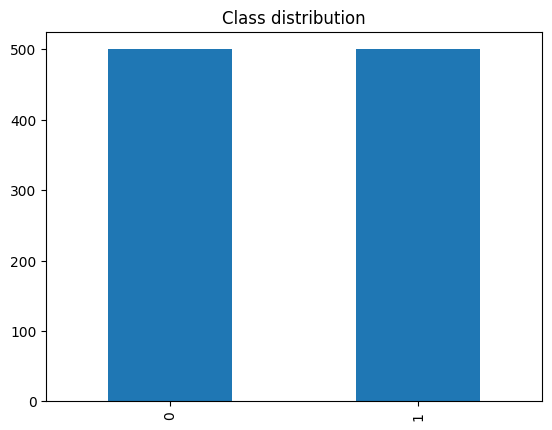

In [3]:
import pandas as pd
from torch_geometric.data import Dataset
from torch_geometric.datasets import TUDataset


dataset = TUDataset(
    root="data",  # where to save dataset
    name="IMDB-BINARY"
)

print(f"Number of classes: {dataset.num_classes}")
print()
dataset.print_summary()
print()
pd.Series(dataset.y).value_counts().plot.bar(title="Class distribution")

### PyTorch Geometric Dataset

1. Built from graphs
2. Regular PyTorch dataset, with indexing etc.
3. Collection of `Data` objects, representing graphs:
   - `edge_index` - adjacency matrix in COO sparse format
   - `num_nodes` - $|V|$
   - `x` - node features
   - `y` - class

In [5]:
graph = dataset[0]

print("Graph:", graph)
print("Adjacency matrix (COO sparse format):", graph.edge_index)
print("Number of nodes:", graph.num_nodes)
print("Node features:", graph.x)
print("Class:", graph.y)

Graph: Data(edge_index=[2, 146], y=[1], num_nodes=20)
Adjacency matrix (COO sparse format): tensor([[ 0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,
          2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,  3,  3,  3,
          3,  3,  4,  4,  4,  4,  4,  5,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,
          6,  6,  6,  6,  6,  7,  7,  7,  8,  8,  8,  8,  8,  8,  8,  8,  9,  9,
          9,  9,  9, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 12, 12, 12, 12,
         12, 12, 12, 12, 12, 12, 12, 13, 13, 13, 14, 14, 14, 14, 14, 14, 14, 14,
         15, 15, 15, 15, 16, 16, 16, 16, 16, 16, 17, 17, 17, 17, 17, 17, 17, 17,
         18, 18, 18, 18, 18, 18, 18, 18, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19,
         19, 19],
        [ 2,  4,  5,  9, 10,  2,  6,  8, 12, 14, 17, 18, 19,  0,  1,  3,  4,  5,
          6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,  2,  6, 11, 12,
         16, 19,  0,  2,  5,  9, 10,  0,  2,  4,  9, 10,  1,  2,  3,  8, 11, 12,

## Local Degree Profile (LDP)

1. Extract LDP features
2. Gather features for all graphs
3. Classify with Random Forest

We will use [PyTorch Geometric code for LDP](https://pytorch-geometric.readthedocs.io/en/latest/_modules/torch_geometric/transforms/local_degree_profile.html), but slightly modified.

In [19]:
import numpy as np
import torch
from torch_geometric.data import Data
from torch_geometric.nn.aggr.fused import FusedAggregation
from torch_geometric.utils import degree


def extract_ldp_features(graph: Data) -> np.ndarray:
    row, col = graph.edge_index
    N = graph.num_nodes

    # compute degree for each node, using adjacency matrix
    deg = degree(row, N, dtype=torch.float).view(-1, 1)

    # compute degree statistics, using node degrees and adjacency matrix
    aggr = FusedAggregation(["min", "max", "mean", "std"])
    aggregated_features = aggr(deg[col], row, dim_size=N)

    # combine features into a single list of Numpy vectors
    aggregated_features = [deg] + aggregated_features
    aggregated_features = [feature.numpy().ravel() for feature in aggregated_features]

    # aggregate each feature with a histogram and concatenate them
    aggregated_features = [np.histogram(feature, bins=50)[0] for feature in aggregated_features]
    aggregated_features = np.hstack(aggregated_features)

    return aggregated_features


In [23]:
from tqdm.notebook import tqdm


def dataset_to_ldp_features(dataset: Dataset) -> np.ndarray:
    X = []
    for graph in tqdm(dataset, total=len(dataset)):
        x = extract_ldp_features(graph)
        X.append(x)

    return np.stack(X)


In [24]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score


def train_ldp(dataset: Dataset) -> None:
    clf = RandomForestClassifier(n_estimators=500, n_jobs=-1)
    X = dataset_to_ldp_features(dataset)
    y = dataset.y.numpy()

    scores = cross_val_score(
        estimator=clf,
        X=X,
        y=y,
        scoring="accuracy",
        cv=10,
    )
    test_acc = np.mean(scores)
    print(f"Test accuracy: {100 * test_acc:.2f}")


In [25]:
train_ldp(dataset)

  0%|          | 0/1000 [00:00<?, ?it/s]

Test accuracy: 69.80


## Local Topological Profile (LTP)

1. Extract LDP features
2. Transform to NetworKit graph
3. Calculate additional LTP features
4. Gather features for all graphs
5. Classify with Random Forest

We will use NetworKit tutorials:
- [edge betweenness centrality](https://networkit.github.io/dev-docs/notebooks/Centrality.html)
- [Jaccard index](https://networkit.github.io/dev-docs/notebooks/LinkPrediction.html)
- [Local Degree Score](https://networkit.github.io/dev-docs/notebooks/Sparsification.html)

In [28]:
from networkit.centrality import Betweenness
from networkit.graph import Graph as NetworkitGraph
from networkit.linkprediction import JaccardIndex
from networkit.nxadapter import nx2nk
from networkit.sparsification import LocalDegreeScore
from torch_geometric.utils import to_networkx


def calculate_edge_betweenness(graph: NetworkitGraph) -> np.ndarray:
    # calculate betweenness and get edge scores
    btwn = Betweenness(graph, computeEdgeCentrality=True)
    btwn.run()
    scores = btwn.scores()

    # to Numpy
    scores = np.array(scores, dtype=np.float32)
    return scores


def calculate_jaccard_index(graph: NetworkitGraph) -> np.ndarray:
    # calculate Jaccard index values
    jaccard = JaccardIndex(graph)
    scores = [jaccard.run(u,v) for u,v in graph.iterEdges()]

    # to Numpy, remove infinite values
    scores = np.array(scores, dtype=np.float32)
    scores = scores[np.isfinite(scores)]
    return scores


def calculate_local_degree_score(graph: NetworkitGraph) -> np.ndarray:
    # calculate Local Degree Score values
    lds = LocalDegreeScore(graph)
    lds.run()
    scores = lds.scores()
    # to Numpy
    scores = np.array(scores, dtype=np.float32)
    return scores


def extract_ltp_features(graph: Data) -> np.ndarray:
    row, col = graph.edge_index
    N = graph.num_nodes

    # compute degree for each node, using adjacency matrix
    deg = degree(row, N, dtype=torch.float).view(-1, 1)

    # compute degree statistics, using node degrees and adjacency matrix
    aggr = FusedAggregation(["min", "max", "mean", "std"])
    aggregated_features = aggr(deg[col], row, dim_size=N)

    # combine features into a single list of Numpy vectors
    aggregated_features = [deg] + aggregated_features
    aggregated_features = [feature.numpy().ravel() for feature in aggregated_features]

    # transform to NetworKit
    graph_networkx = to_networkx(graph, to_undirected=True)
    graph_networkit = nx2nk(graph_networkx)
    graph_networkit.indexEdges()

    # calculate additional features
    ebc = calculate_edge_betweenness(graph_networkit)
    jaccard_index = calculate_jaccard_index(graph_networkit)
    lds = calculate_local_degree_score(graph_networkit)

    aggregated_features.extend([ebc, jaccard_index, lds])

    # aggregate each feature with a histogram and concatenate them
    aggregated_features = [np.histogram(feature, bins=50)[0] for feature in aggregated_features]
    aggregated_features = np.hstack(aggregated_features)


    return aggregated_features


In [29]:
def dataset_to_ltp_features(dataset: Dataset) -> np.ndarray:
    X = []
    for graph in tqdm(dataset, total=len(dataset)):
        x = extract_ltp_features(graph)
        X.append(x)

    return np.stack(X)


In [32]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score


def train_ltp(dataset: Dataset) -> None:
    clf = RandomForestClassifier(n_estimators=500, n_jobs=-1)
    X = dataset_to_ltp_features(dataset)
    y = dataset.y.numpy()

    scores = cross_val_score(
        estimator=clf,
        X=X,
        y=y,
        scoring="accuracy",
        cv=10,
    )
    test_acc = np.mean(scores)
    print(f"Test accuracy: {100 * test_acc:.2f}")


In [33]:
train_ltp(dataset)

  0%|          | 0/1000 [00:00<?, ?it/s]

Test accuracy: 72.60
